# Proyecto - 3DCNN

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os
from sklearn.metrics import precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [16]:
class WeightedMultiLabelLogLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedMultiLabelLogLoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        """
        Computes the weighted multi-label logarithmic loss.

        Args:
            input (torch.Tensor): Predicted probabilities (output of the model).
                                Shape: (batch_size, num_classes)
            target (torch.Tensor): Target labels (ground truth).
                                Shape: (batch_size, num_classes)

        Returns:
            loss (torch.Tensor): Weighted multi-label logarithmic loss.
        """
        epsilon = 1e-15  # Small constant to avoid log(0)

        # Log loss
        log_loss = -target * torch.log(input + epsilon) - (1 - target) * torch.log(1 - input + epsilon)

        # Apply weights if provided
        if self.weight is not None:
            log_loss = log_loss * self.weight

        # Compute mean loss over samples and classes
        loss = log_loss.mean()

        return loss

In [17]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        
        # Capa 3D Conv1
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Capa 3D Conv2
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        #Forzar dimensionalidad
        self.fce = nn.Linear(4800, 2400) # (64 * 75, 64*75/2)
        self.relue1 = nn.ReLU()  
        self.fce2 = nn.Linear(2400, 240)
        self.relue2 = nn.ReLU()
        self.fce3 = nn.Linear(240, 128)
        self.relue3 = nn.ReLU()
        self.fce4 = nn.Linear(128, 1)    
          
        # Capa completamente conectada
        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 7)
        
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # forzar dimensionalidad
        x = x.view(-1, 64 * 75)
        x = self.fce(x)
        x = self.relue1(x)
        x = self.fce2(x)
        x = self.relue2(x)
        x = self.fce3(x)
        x = self.relue3(x)
        x = self.fce4(x)
        
        
        x = x.view(-1, 64 * 4 * 4 * 4)        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        x = self.softmax(x)
        
        return x

# # Crear una instancia del modelo
# num_classes = 7  # Número de clases de salida
# model = Simple3DCNN(num_classes)

# # Imprimir el modelo para ver su estructura
# print(model)


In [18]:
first_object = np.load('volumes/1.2.826.0.1.3680043.1010.npy')

first_object.shape

(256, 256, 300)

In [19]:
#Cargar datos 

class ImageDataGenerator:
    def __init__(self, volumes_ruta, csv, max_UID):
        self.volumes_ruta = volumes_ruta
        self.max_UID = max_UID
        self.current_UID = 0
        self.names = []
        self.df = csv
        self.read_volumes_path()
        
    def read_volumes_path(self):
        ruta_carpeta = self.volumes_ruta
        if os.path.exists(ruta_carpeta) and os.path.isdir(ruta_carpeta):
            objetos = os.listdir(ruta_carpeta)
            print(objetos)
            for objeto in objetos:
                objeto_ruta = os.path.join(ruta_carpeta, objeto)
                self.names.append(objeto_ruta)

    def reset_idx(self):
        self.current_UID = 0  
        
    def get_next_ruta(self):
        next_name = 'volumes/' + self.df.iloc[self.current_UID]['StudyInstanceUID'] + '.npy'
        return next_name
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_UID >= self.max_UID:
            # print("No hay mas datos")
            self.current_UID = 0
            raise StopIteration()
        else:
            # Cargar el volumen
            name = self.get_next_ruta()
            volume = np.load(name)
            #volume.resize((256, 256, 256))
            #label = [float(value) for value in self.df.iloc[self.current_UID][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].tolist()]
            label = self.df.iloc[self.current_UID][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].tolist()
            # Incrementar el UID
            self.current_UID += 1
            # Devolver el volumen
            return volume, label
        
    def __len__(self):
        # Devuelve la longitud total del generador
        return self.max_UID

In [20]:
num_classes = 7
model3D = Simple3DCNN(num_classes)

In [21]:
if torch.cuda.is_available():
    print('GPU está disponible')
else:
    print('No se encontró GPU, usando CPU')

GPU está disponible


In [22]:
import torch
print(torch.cuda.is_available())

True


In [23]:
model3D.to('cuda')

Simple3DCNN(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu1): ReLU()
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu2): ReLU()
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fce): Linear(in_features=4800, out_features=2400, bias=True)
  (relue1): ReLU()
  (fce2): Linear(in_features=2400, out_features=240, bias=True)
  (relue2): ReLU()
  (fce3): Linear(in_features=240, out_features=128, bias=True)
  (relue3): ReLU()
  (fce4): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)

In [24]:
data = pd.read_csv('train_filtrado_volumes.csv')
data = data.iloc[0:600]

In [25]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [26]:
sample = 1005
# ARREGLAR
data_gen = ImageDataGenerator('volumes', train_data, len(train_data))
test_data_gen = ImageDataGenerator('volumes', test_data, len(test_data))

['1.2.826.0.1.3680043.10001.npy', '1.2.826.0.1.3680043.10005.npy', '1.2.826.0.1.3680043.10014.npy', '1.2.826.0.1.3680043.10016.npy', '1.2.826.0.1.3680043.10032.npy', '1.2.826.0.1.3680043.10041.npy', '1.2.826.0.1.3680043.10051.npy', '1.2.826.0.1.3680043.10058.npy', '1.2.826.0.1.3680043.10062.npy', '1.2.826.0.1.3680043.1010.npy', '1.2.826.0.1.3680043.10136.npy', '1.2.826.0.1.3680043.1016.npy', '1.2.826.0.1.3680043.10179.npy', '1.2.826.0.1.3680043.10204.npy', '1.2.826.0.1.3680043.10230.npy', '1.2.826.0.1.3680043.10261.npy', '1.2.826.0.1.3680043.10360.npy', '1.2.826.0.1.3680043.10400.npy', '1.2.826.0.1.3680043.10412.npy', '1.2.826.0.1.3680043.10431.npy', '1.2.826.0.1.3680043.10443.npy', '1.2.826.0.1.3680043.10449.npy', '1.2.826.0.1.3680043.10515.npy', '1.2.826.0.1.3680043.10520.npy', '1.2.826.0.1.3680043.10541.npy', '1.2.826.0.1.3680043.10579.npy', '1.2.826.0.1.3680043.10606.npy', '1.2.826.0.1.3680043.10608.npy', '1.2.826.0.1.3680043.10614.npy', '1.2.826.0.1.3680043.1062.npy', '1.2.826.0.1

In [27]:
# Especifica la carpeta donde se almacenarán los registros de TensorBoard
log_dir = "logs_3D"

# Inicializa TensorBoard
writer = SummaryWriter(log_dir=os.path.join(log_dir, 'loss'))
accuracy_writer = SummaryWriter(log_dir=os.path.join(log_dir, 'accuracy'))
F1_writer = SummaryWriter(log_dir=os.path.join(log_dir, 'F1'))

In [28]:
learning_rate = 1e-3
num_epochs = 6
display_step = 4

criterion = WeightedMultiLabelLogLoss()
optimizer = optim.Adam(model3D.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
F1_list = []
accuracy_list = []

model3D.train()

total_accuracy = 0
total_f1 = 0

for epoch in range(num_epochs):
    optimizer.zero_grad()
    running_loss = 0.0
    running_F1 = 0.0
    running_accuracy = 0.0
    loss_acum = 0.0
    F1_acum = 0.0
    accuracy_acum = 0.0
    counter = 0
    data_gen.reset_idx()
    # try:
    for i, (volume, label) in tqdm(enumerate(data_gen), total=len(data_gen)):
        try:
            image_tensor = torch.from_numpy(volume).unsqueeze(0).float().to('cuda')
            label_tensor = torch.tensor(label).unsqueeze(0).float().to('cuda')


            predictions = model3D(image_tensor)
            threshold = 0.5
            predicted_labels = (predictions > threshold).float()  # 1 si es mayor al umbral, 0 de lo contrario
            predicted_labels_np = predicted_labels.cpu().numpy()[0]

            accuracy_per_class = (predicted_labels_np == label).mean(axis=0)

            # Calcular la precisión global (promedio de la precisión por clase)
            number_of_1 = np.count_nonzero(label)
            intersection = np.logical_and(predicted_labels_np, label)
            intersection_1 = np.count_nonzero(intersection)
            accuracy_iter = 0
            if  number_of_1 == 0:
                if intersection_1 > number_of_1:
                    accuracy_iter = 0
                elif intersection_1 == 0:
                    accuracy_iter = 1
            else:
                accuracy_iter = intersection_1 / number_of_1

            total_accuracy += accuracy_iter
            running_accuracy += accuracy_iter
            accuracy_acum += accuracy_iter
            #----------------------------------------
            #accuracy = accuracy_per_class.mean()
            #print(label, predicted_labels_np)
            #weighted_precision = precision_score(label, predicted_labels_np, average='weighted')

            # Calcular el F1-score ponderado
            total_f1 += f1_score(label, predicted_labels_np, average='weighted')
            running_F1 += f1_score(label, predicted_labels_np, average='weighted')
            F1_acum += f1_score(label, predicted_labels_np, average='weighted')

            #print("->",predictions)
            #print("Shape ->",predictions.shape)
            #print("-->",label_tensor)
            loss = criterion(predictions, label_tensor)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_acum += loss.item()

            # Actualizar la pérdida en tiempo real en TensorBoard
            if i % display_step == display_step - 1:
                avg_loss = running_loss / display_step
                writer.add_scalar('Loss', avg_loss, epoch * len(data_gen) + i)

                running_loss = 0.0

            # Actualizar la precisión en tiempo real en TensorBoard
            if i % display_step == display_step - 1:
                avg_accuracy = running_accuracy / display_step
                accuracy_writer.add_scalar('Accuracy', avg_accuracy, epoch * len(data_gen) + i)
                running_accuracy = 0.0

            # Actualizar el F1-score en tiempo real en TensorBoard
            if i % display_step == display_step - 1:
                avg_f1 = running_F1 / display_step
                F1_writer.add_scalar('F1', avg_f1, epoch * len(data_gen) + i)
                running_F1 = 0.0
            counter += 1
        except Exception as e:
            print(e)
            continue
    # except:
    #     pass

    avg_train_loss = running_loss / counter
    train_losses.append(avg_train_loss)
    F1_list.append(F1_acum / counter)
    accuracy_list.append(accuracy_acum / counter)

    # if epoch % 1 == 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, avg_train_loss))

    model3D.eval()
    with torch.no_grad():
        running_test_loss = 0.0
        for i, (volume, label) in enumerate(test_data_gen): # Asume que test_data_gen es tu generador de datos de prueba
            image_tensor = torch.from_numpy(volume).unsqueeze(0).float().to('cuda')
            label_tensor = torch.tensor(label).unsqueeze(0).float().to('cuda')

            predictions = model3D(image_tensor)
            loss = criterion(predictions, label_tensor)

            running_test_loss += loss.item()

        avg_test_loss = running_test_loss / len(test_data_gen)
        test_losses.append(avg_test_loss)

    model3D.train()

print('Loss: ', loss.item())
print('Accuracy: ', total_accuracy / len(data_gen))
print('F1', total_f1 / len(data_gen))



  1%|          | 3/480 [00:36<1:36:24, 12.13s/it]


KeyboardInterrupt: 

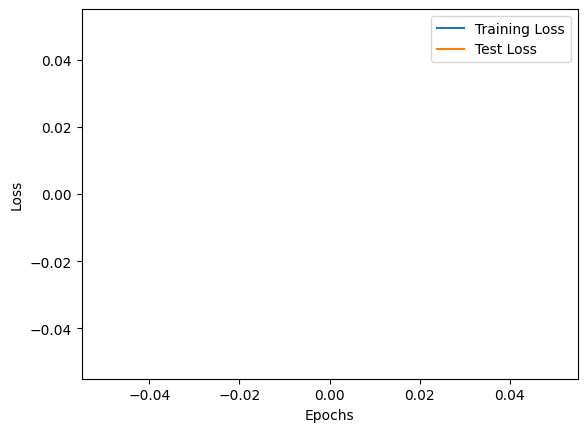

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Supongamos que ya has entrenado el modelo y deseas guardarlo
torch.save(model3D.state_dict(), 'modelo_entrenado3D.pth')